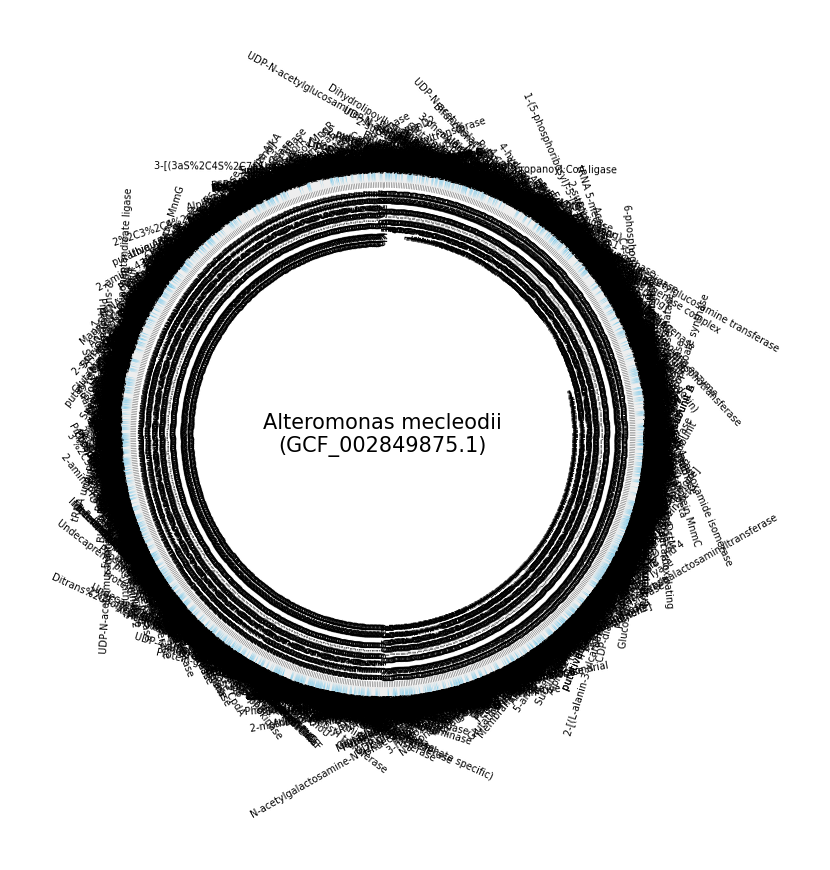

In [1]:
from pycirclize import Circos
from pycirclize.parser import Gff
from pycirclize.utils import load_prokaryote_example_file

# Load GFF file
gff = Gff("genome.gff")

# Initialize circos instance
seqid2size = gff.get_seqid2size()
space = 0 if len(seqid2size) == 1 else 2
circos = Circos(sectors=seqid2size, space=space)
circos.text("Alteromonas mecleodii\n(GCF_002849875.1)", size=15)

seqid2features = gff.get_seqid2features(feature_type="CDS")
for sector in circos.sectors:
    cds_track = sector.add_track((90, 100))
    cds_track.axis(fc="#EEEEEE", ec="none")

    features = seqid2features[sector.name]
    label_pos_list, labels = [], []
    for feature in features:
        # Plot CDS features
        if feature.location.strand == 1:
            cds_track.genomic_features(feature, plotstyle="arrow", r_lim=(95, 100), fc="salmon")
        else:
            cds_track.genomic_features(feature, plotstyle="arrow", r_lim=(90, 95), fc="skyblue")
        # Extract feature product label & position
        start, end = int(feature.location.start), int(feature.location.end)
        label_pos = (start + end) / 2
        label = feature.qualifiers.get("product", [""])[0]
        if label == "" or label.startswith("hypothetical"):
            continue
        cds_track.text(text=label, x=label_pos, size=7, adjust_rotation=True)

    # Plot xticks & intervals on inner position
    cds_track.xticks_by_interval(
        interval=5000,
        outer=False,
        label_formatter=lambda v: "{:.1f} Kb".format(v / 1000),
        label_orientation="vertical",
        line_kws=dict(ec="grey"),
    )

fig = circos.plotfig()
fig.savefig("circos_plot1.png", dpi=300)

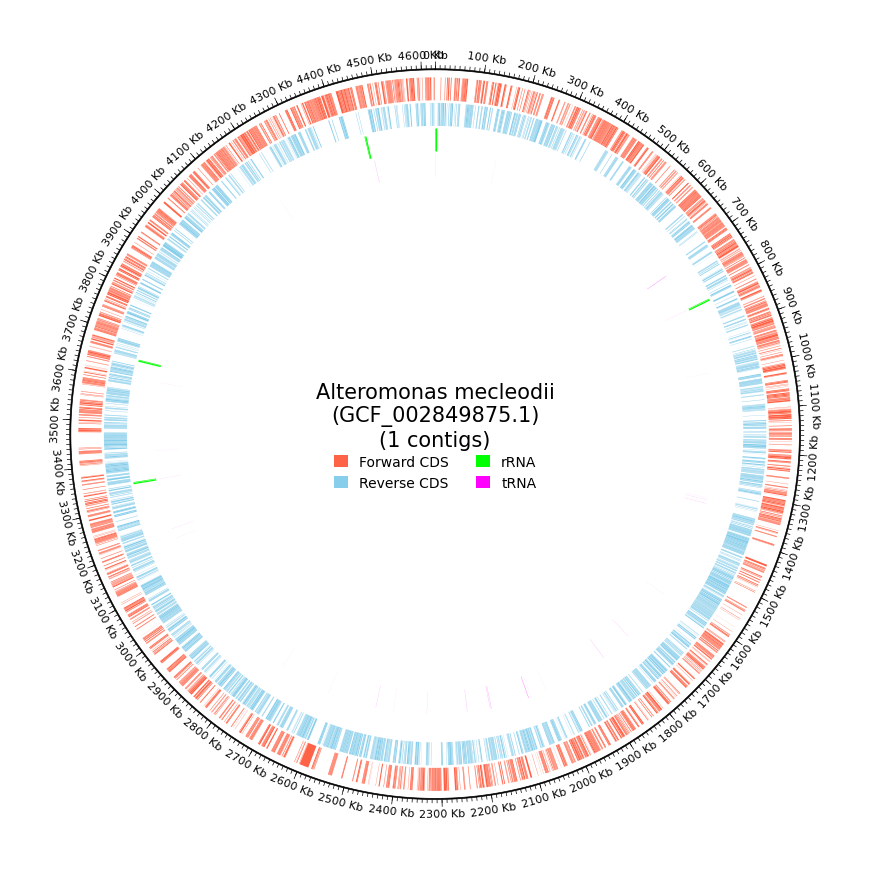

In [2]:
from pycirclize import Circos
from pycirclize.parser import Gff, Genbank
from pycirclize.utils import load_prokaryote_example_file
from matplotlib.patches import Patch

# Case1. Load `GFF` contig genomes
# https://github.com/moshi4/pycirclize-data/blob/main/prokaryote/mycoplasma_alvi.gff
# gff_file = Gff("genome.gff")
parser = Gff("genome.gff")

# Case2. Load `Genbank` contig genomes
# https://github.com/moshi4/pycirclize-data/blob/main/prokaryote/mycoplasma_alvi.gbk
# gbk_file = load_prokaryote_example_file("mycoplasma_alvi.gbk")
# parser = Genbank(gbk_file)

# Initialize circos instance
seqid2size = parser.get_seqid2size()
space = 0 if len(seqid2size) == 1 else 2
circos = Circos(seqid2size, space=space)
circos.text(f"Alteromonas mecleodii\n(GCF_002849875.1)\n({len(circos.sectors)} contigs)", r=5, size=15)

seqid2features = parser.get_seqid2features(feature_type=None)
for sector in circos.sectors:
    # Plot outer track
    outer_track = sector.add_track((99.7, 100))
    outer_track.axis(fc="black")
    major_interval = 100000
    minor_interval = int(major_interval / 10)
    if sector.size > minor_interval:
        outer_track.xticks_by_interval(major_interval, label_formatter=lambda v: f"{v / 1000:.0f} Kb")
        outer_track.xticks_by_interval(minor_interval, tick_length=1, show_label=False)

    # Plot forward/reverse CDS, rRNA, tRNA tracks
    f_cds_track = sector.add_track((91, 98), r_pad_ratio=0.1)
    r_cds_track = sector.add_track((84, 91), r_pad_ratio=0.1)
    rrna_track = sector.add_track((77, 84), r_pad_ratio=0.1)
    trna_track = sector.add_track((70, 77), r_pad_ratio=0.1)
    for feature in seqid2features[sector.name]:
        if feature.type == "CDS":
            if feature.location.strand == 1:
                f_cds_track.genomic_features([feature], fc="tomato")
            else:
                r_cds_track.genomic_features([feature], fc="skyblue")
        elif feature.type == "rRNA":
            rrna_track.genomic_features([feature], fc="lime")
        elif feature.type == "tRNA":
            trna_track.genomic_features([feature], fc="magenta")

fig = circos.plotfig()
_ = circos.ax.legend(
    handles=[
        Patch(color="tomato", label="Forward CDS"),
        Patch(color="skyblue", label="Reverse CDS"),
        Patch(color="lime", label="rRNA"),
        Patch(color="magenta", label="tRNA"),
    ],
    bbox_to_anchor=(0.5, 0.45),
    loc="center",
    ncols=2,
)
fig.savefig("circos_plot2.png", dpi=300)